In [2]:
# import all necessary external dependencies
import os
import sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.append(ROOT_DIR)
from env.lib import *
import jaxopt

Define partial traces operator.

In [3]:
def tr_1(A: jnp.ndarray) -> jnp.ndarray:
    """
    computes first partial trace of an operator A
    """
    n = jnp.sqrt(jnp.shape(A)[0]).astype(int) # reshape A into a rank 4 tensor
    return jnp.einsum('ijkl->jl', A.reshape(n,n,n,n)) / n

def tr_2(A: jnp.ndarray) -> jnp.ndarray:
    """
    computes second partial trace of an operator A
    """
    n = jnp.sqrt(jnp.shape(A)[0]).astype(int) # reshape A into a rank 4 tensor
    return jnp.einsum('ijkl->ik', A.reshape(n,n,n,n)) / n

Define gradients of dual functional as

$
\nabla_U D_\epsilon(U,V) = \varepsilon\rho_1 - \mathrm{Tr}_2[(U\oplus V - C)_+]
$

and

$
\nabla_V D_\epsilon(U,V) = \varepsilon\rho_2 - \mathrm{Tr}_1[(U\oplus V - C)_+]
$

In [4]:
def grad_U(Gamma: jnp.ndarray, rho_1: jnp.ndarray, epsilon: float) -> jnp.ndarray:
    """
    computes gradient of the dual functional with respect to U
    """
    return epsilon * rho_1 - tr_2(Gamma)

def grad_V(Gamma: jnp.ndarray, rho_2: jnp.ndarray, epsilon: float) -> jnp.ndarray:
    """
    computes gradient of the dual functional with respect to V
    """
    return epsilon * rho_2 - tr_1(Gamma)

Perform change of basis of operators defined on $\mathcal{H}$, $\mathcal{K}$, or $\mathcal{H} \otimes \mathcal{K}$ with respect to the change of basis in the space of $\mathcal{H} \otimes \mathcal{K}$.

In [5]:

def change_of_basis_matrix(P_old: jnp.ndarray, P_new: jnp.ndarray) -> jnp.ndarray:
	"""
	Computes a change of basis matrix to switch from P_old to P_new
	"""
	return jnp.linalg.solve(P_old, P_new)

def represent(A: jnp.ndarray, change_of_basis_matrix: jnp.ndarray) -> jnp.ndarray:
	"""
	Computes the new representation of an operator A under change_of_basis matrix
	"""
	return jnp.linalg.solve(change_of_basis_matrix, A @ change_of_basis_matrix)


def represent_H(A: jnp.ndarray, change_of_basis_matrix: jnp.ndarray) -> jnp.ndarray:
    n = jnp.shape(A)[0]
    lifted_A = jnp.kron(A, jnp.eye(n))
    repr_lifted_A = jnp.linalg.solve(change_of_basis_matrix, lifted_A @ change_of_basis_matrix)
    return tr_2(repr_lifted_A)

def represent_K(A: jnp.ndarray, change_of_basis_matrix: jnp.ndarray) -> jnp.ndarray:
    n = jnp.shape(A)[0]
    lifted_A = jnp.kron(jnp.eye(n), A)
    repr_lifted_A = jnp.linalg.solve(change_of_basis_matrix, lifted_A @ change_of_basis_matrix)
    return tr_1(repr_lifted_A)

Auxiliary Diagonalization tools.

In [6]:
def clip_diagonalize(A: jnp.ndarray) -> jnp.ndarray:
    """
    Diagonalize and clip the matrix A to have nonnegative eigenvalues
    """
    return jnp.diag(jnp.clip(jnp.linalg.eigvalsh(A), a_min=0, a_max=None))

def diagonalize(A: jnp.ndarray):
    """
    Diagonalize the matrix A such that A=PDP^{-1}
    """
    D, P = jnp.linalg.eigh(A)
    return jnp.diag(D), P

### Hilbert-Schmidt Norm
Let $\mathrm{H}(X)$ be a vector space of Hermitian operators on a finite dimensional Hilbert space $X$. Then, $\vert\vert \cdot \vert\vert_{HS}: \mathrm{H}(X) \to \mathbb{R}_{\geq 0}$ is defined as

$
\vert\vert A \vert\vert_{HS} = \sqrt{\mathrm{Tr}\left[A^*A\right]} \geq \sqrt{\sum_{i=1}^{\dim X} \lambda_i^2} = \sqrt{\mathrm{Tr}\left[\sum_{i=1}^{\dim X}\lambda_i^2 \ket{\xi_i}\bra{\xi_i}\right]}
$

where $\lambda_i$'s are eigenvalues of the Hermitian operator $A \in \mathrm{H}(X)$.

In [7]:
def hilbert_schmidt(A: jnp.ndarray) -> float:
    """
    Compute Hilbert-Schmidt norm of a matrix A
    """
    return jnp.sqrt(jnp.trace(jnp.absolute(A.conjugate().T @ A)))

Using this setup, the `compute_error` function is defined as the maximum of Hilbert-Schmidt norms of differences projected on each Hilbert space $\mathcal{H}$ and $\mathcal{K}$. $$\mathrm{Error}(A,\rho_1,\rho_2) = \max(\lvert\lvert\mathrm{Tr}_1[\Gamma]-\rho_2\rvert\rvert_{HS}, \lvert\lvert\mathrm{Tr}_2[\Gamma]-\rho_1\rvert\rvert_{HS})$$.

In [8]:
def compute_error(Gamma: jnp.ndarray, rho_1: jnp.ndarray, rho_2: jnp.ndarray) -> float:
    """
    Compute the error of the quantum gradient descent
    """
    diff_H = tr_1(Gamma) - rho_2 # error on the first hilbert space H
    diff_K = tr_2(Gamma) - rho_1 # error on the second hilbert space K
    return max(hilbert_schmidt(diff_H), hilbert_schmidt(diff_K))

### Quantum Gradient Descent
We formulate the gradient descent algorithm as follows.

In [9]:
def quantum_gradient_descent(C: jnp.ndarray, rho_1: jnp.ndarray, rho_2: jnp.ndarray, epsilon: float = 1, 
                             num_iter: int = 50000, convergence_error: float = 1e-9):
    """
	Run Quantum Gradient Descent algorithm for Quadratic Regularization
	"""
    start_time = time.time()
    n, m = rho_1.shape[0], rho_2.shape[0]
    step_size = 1.0 / (m*n)
    error, iterations = convergence_error * 2, 0
    U, V = jnp.zeros_like(rho_1), jnp.zeros_like(rho_2)
    P_old, P_new = jnp.eye(n*m), jnp.eye(n*m)
    Gamma = jnp.zeros_like(C)
    err_list = []
    
    for k in trange(num_iter):
        
        # update quantum coupling
        Gamma = jnp.kron(U, jnp.eye(m)) + jnp.kron(jnp.eye(n), V) - C
        Gamma = clip_diagonalize(Gamma) # normalize for nonnegative eigenvalues
        Gamma, P_new = diagonalize(Gamma) # obtain eigenbasis for updated Gamma
        
        # change the representation into a new basis
        Q = change_of_basis_matrix(P_old, P_new) # obtain change of basis matrix
        U = represent_H(U, Q)
        V = represent_K(V, Q)
        rho_1 = represent_H(rho_1, Q)
        rho_2 = represent_K(rho_2, Q)

        # compute error of the updated Gamma and decide termination
        error = compute_error(Gamma, rho_1, rho_2)
        err_list.append(error)
        if error < convergence_error:
            iterations = k
            break

        # gradient descent updates
        U += step_size * grad_U(Gamma, rho_1, epsilon)
        V += step_size * grad_V(Gamma, rho_2, epsilon)
        
        P_old = P_new # update the eigenbasis matrix
    
    end_time = time.time()
    time_taken = end_time - start_time
    logger.success(f"Gradient Descent | Elapsed: {time_taken} | Precision: {error}.")
    return Gamma, error, err_list, iterations, time_taken

### Unit Test

100%|██████████| 1000/1000 [00:09<00:00, 102.20it/s]
2024-08-21 12:23:41.909 | SUCCESS  | __main__:quantum_gradient_descent:44 - Gradient Descent | Elapsed: 9.843427181243896 | Precision: 97.94133965088041.


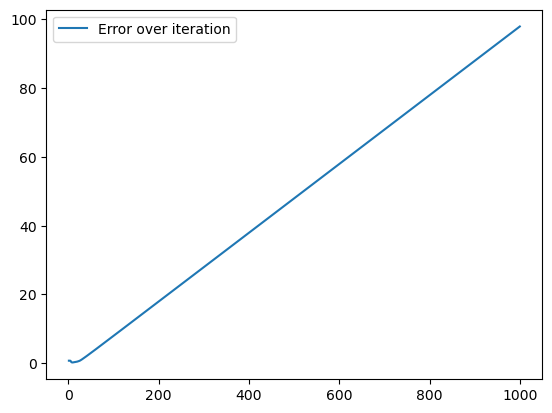

[[  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.         197.08084146]]


In [10]:
rho_1 = jnp.array([[0.4, 0.1], [0.1, 0.6]])
rho_2 = jnp.array([[0.4, 0.1], [0.1, 0.6]])
cost = jnp.eye(rho_1.shape[0]**2)

Gamma, error, err_lst, iters, elapsed_time = quantum_gradient_descent(cost, rho_1, rho_2, convergence_error=1e-3, num_iter=1000)

x = np.linspace(start=1,stop=len(err_lst), num=len(err_lst), endpoint=True)
plt.plot(x, err_lst, label=rf'Error over iteration')
plt.legend()
plt.show()

print(Gamma)

### Unit Test for Scipy Optimizers

Define Frobenius inner product $\langle A, B \rangle = Tr[AB^\dagger]$.

In [11]:
def frob_inner(A, B):
    return jnp.sum(A * B)

Define the Dual Functional $D_\epsilon(U,V) = \langle U, \rho_1 \rangle + \langle V, \rho_2 \rangle - \epsilon Tr\left[\frac{1}{2}\left(\frac{U\oplus V - H}{\epsilon}\right)_+^2\right]$

In [12]:
def clip_diagonalize(A):
    eigenvalues, eigenvectors = jnp.linalg.eigh(A) # diagonalize
    eigenvalues = jnp.maximum(eigenvalues, 0) # clip to be nonnegative
    clip_diagonal = jnp.diag(eigenvalues) # normalized diagonal matrix
    A_new = eigenvectors @ clip_diagonal @ eigenvectors.T # represent in the original basis
    return A_new

def dual_functional(U: jnp.ndarray, V: jnp.ndarray, cost: jnp.ndarray, rho_1: jnp.ndarray, rho_2: jnp.ndarray, eps: float):
    C_plus = clip_diagonalize((jnp.kron(U, V) - cost))
    return 2 * eps * frob_inner(U, rho_1) + 2 * eps * frob_inner(V, rho_2) - frob_inner(C_plus, C_plus)

Define a wrapper for `dual_functional` for the use of optimizers.

In [13]:
def objective_func(params, cost, marginals, eps):
    n = marginals[0].shape[0]
    U, V = params[:n], params[n:]
    return dual_functional(U, V, cost, marginals[0], marginals[1], eps)

In [14]:
MAXITER = 500

def maximize_lagrange(optimizer, marginal, cost, epsilon):
    # initialize potentials
    U0, V0 = jnp.zeros_like(marginal[0]), jnp.zeros_like(marginal[1])
    UV0 = jnp.concatenate([U0, V0])

    # select optimizer
    if optimizer == "gradient-descent":
        solver = jaxopt.GradientDescent(fun=objective_func, maxiter=MAXITER)
    elif optimizer == "nonlinear-CG":
        solver = jaxopt.NonlinearCG(fun=objective_func, method="polak-ribiere", maxiter=MAXITER)
    elif optimizer == "LBFGS":
        solver = jaxopt.LBFGS(fun=objective_func, maxiter=MAXITER)
    else:
        solver = jaxopt.ScipyMinimize(fun=objective_func, method=optimizer, maxiter=MAXITER)
    res = solver.run(init_params=UV0, cost=cost, marginals=marginal, eps=epsilon)

    # unpack results
    params, state = res
    
    n = marginal[0].shape[0]
    U, V = params[:n], params[n:]

    # Reconstruct coupling
    C_plus = clip_diagonalize((np.kron(U, V) - cost))
    return C_plus/epsilon


Run the test.

In [17]:
lst_optimizers = ['gradient-descent', 'nonlinear-CG', 'LBFGS', 'L-BFGS-B', 'trust-const', 'BFGS', 'COBYLA', 'SLSQP', 'Newton-CG']

epsilon_lst = [100, 10, 5]

marginals_lst_1 = [jnp.array([[0.5, 0  ],
                              [0,   0.5]]),
                    jnp.array([[0.5, 0  ],
                              [0,   0.5]])]

marginals_lst_2 = [jnp.array([[0.4, 0.1 ],
                              [0.1,   0.6]]),
                    jnp.array([[0.5, 0.1 ],
                              [0.1,   0.5]])]

marginals_lst_3 = [np.random.rand(2,2),
                   np.random.rand(2,2)]

table = {'success': [],
         'marg_error': [],
         'method': [],
         'penalty': [],
         'set': [],
         'coupling_error':[]}

errors = []
### looping over the differrent optimizers
for set_num, marginal in enumerate([marginals_lst_2,
                                    
                                    ]):
    cost = jnp.eye(marginal[0].shape[0]**len(marginal))
    for optimizer in lst_optimizers:
        ### looping over the epsilon:
        for epsilon in epsilon_lst:
            res = maximize_lagrange(optimizer=optimizer, marginal=marginal, cost=cost, epsilon=epsilon)
            print(res)
            """
            reconstruct_mrgnls = res['approx_mrgnls'] 

            table['success'].append(res['opt_result'].success)
            table['marg_error'].append(np.linalg.norm(reconstruct_mrgnls-jnp.array(marginal)))
            table['penalty'].append(epsilon)
            table['method'].append(optimizer)
            table['set'].append(set_num)
            table['coupling_error'].append(np.linalg.norm(res['coupling']-functools.reduce(np.kron, 
                                                                            marginal)))
            """
# pd.DataFrame(table)

[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


c:\Users\Dohyoung\.conda\envs\FUSRP\Lib\site-packages\jax\_src\core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\Dohyoung\.conda\envs\FUSRP\Lib\site-packages\jax\_src\core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:1.0  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.5  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.25  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.0625  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.03125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 7 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.01562

c:\Users\Dohyoung\.conda\envs\FUSRP\Lib\site-packages\jax\_src\core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\Dohyoung\.conda\envs\FUSRP\Lib\site-packages\jax\_src\core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:1.0  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.5  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.25  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.0625  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.03125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 7 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.01562

c:\Users\Dohyoung\.conda\envs\FUSRP\Lib\site-packages\jax\_src\core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\Dohyoung\.conda\envs\FUSRP\Lib\site-packages\jax\_src\core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:1.0  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.5  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.25  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.0625  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.03125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 7 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.01562

ValueError: Unknown solver trust-const

In [16]:
output = pd.DataFrame(table)
output[output['set'] == 4]

NameError: name 'pd' is not defined

In [ ]:
coupling = qmarg.maximize_lagrange(marginals_lst_2, np.eye(4), 0.01)['coupling']
np.allclose(coupling, np.kron(*marginals_lst_2), rtol=1e-3)

True

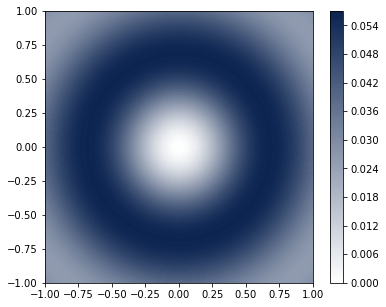

In [ ]:
import qutip as qt
from qutip.wigner import wigner
from qutip.matplotlib_utilities import wigner_cmap
import matplotlib
import matplotlib.pyplot as plt

def wigner_vis(coupling_or_marginal, dims, xvec=np.linspace(-1,1,100)):
    coupling_or_marginal /= np.trace(coupling_or_marginal)
    p_operator = qt.Qobj(list(coupling_or_marginal), dims=dims)
    W = wigner(p_operator, xvec, xvec)
    fig, ax = plt.subplots(figsize=(6,5))
    wmap = wigner_cmap(W)
    plot = ax.contourf(xvec, xvec, W, 100, cmap=wmap)
    fig.colorbar(plot)
    
d = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=np.float32)


# dims should be [first_system.shape, second_system.shape, ...]
# for instance if coupling is 4x4, dims=[[2,2], [2,2]]
wigner_vis(d, [[2,2], [2,2]])

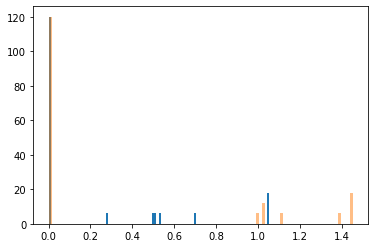

In [ ]:
plt.hist(output['coupling_error'][output['success'] == True].values, bins=100)
plt.hist(output['marg_error'][output['success'] == True].values, bins=100, alpha=0.5)
plt.show();